### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt
from tqdm import tqdm
# Import the environment
from Env import CabDriver

#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

In [3]:
Time_matrix[0][0][21][6]

0.0

In [4]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [5]:
class DQNAgent:
    def __init__(self, state_size, action_size, discount_factor=0.95, learning_rate=0.01,
                       epsilon=1, epsilon_decay=0.99, epsilon_min=0.01):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = discount_factor
        self.learning_rate =  learning_rate      
        self.epsilon_max = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)
        
        # Initialize the value of the states tracked
        self.states_tracked = []

        # We are going to track state [0,0,0] and action (0,2) at index 2 in the action space.
        self.track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36)
        
        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       

        # hidden layers
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))

        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model



    def get_action(self, state, episode, possible_actions_index, actions):
    # Write your code here:
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment       
        self.epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp(-0.0009*episode)
        
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from all possible actions
            return random.choice(possible_actions_index)
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            state = np.array(env.state_encod_arch1(state)).reshape(1, self.state_size)
            q_value = self.model.predict(state)
            
            qval_possible = [q_value[0][i] for i in possible_actions_index]
            
            return possible_actions_index[np.argmax(qval_possible)]
        

    def append_sample(self, state, action, reward, next_state, done):
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state, done))

    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            
            update_output = np.zeros((self.batch_size, self.state_size))
            update_input = np.zeros((self.batch_size, self.state_size))
            
            actions, rewards, done = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, done_element_wise = mini_batch[i]
                update_input[i] = env.state_encod_arch1(state)
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch1(next_state)       
                done.append(done_element_wise)


            # Write your code from here
            # 1. Predict the target from earlier model
            target = self.model.predict(update_input)


            # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output)

            #3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
                
                
        # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)

    def save_tracking_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        # Grab the q_value of the action index that we are tracking.
        self.states_tracked.append(q_value[0][2])

    def save_test_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index that we are tracking.
        self.states_tracked.append(q_value[0][2])
        
    def save(self, name):
        self.model.save(name)       


In [6]:
per_episode_time = 24*30 #24 hours /day and 30 days before the car has to be recharged
Episodes = 10000
rewards_per_episode=[]
episodes=[]
m = 5
t = 24
d = 7

# Call the environment
env = CabDriver()
# Call all the initialised variables of the environment
action_space, state_space, state = env.reset()

#Call the DQN agent
agent = DQNAgent(m+t+d, len(action_space))

### DQN block

In [7]:
score_tracked = []
start_time = time.time()

for episode in tqdm(range(Episodes)):

    # Write code here
    
    score = 0

    total_time_driven = 0
    terminal_state = False
    
    while terminal_state != True:

        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        possible_actions_indices, actions = env.requests(state)
        
        action_index = agent.get_action(state, episode, possible_actions_indices, actions)
        
        action = env.action_space[action_index]
        
        # 2. Evaluate your reward and next state
        next_state, reward, time_taken_for_curr_action = env.step(state, action, Time_matrix)
        total_time_driven += time_taken_for_curr_action
        terminal_state = (total_time_driven > per_episode_time)
        
        if terminal_state != True:
            # 3. Append the experience to the memory
            agent.append_sample(state, action_index, reward, next_state, terminal_state)

            # 4. Train the model by calling function agent.train_model
            agent.train_model()

            # 5. Keep a track of rewards, Q-values, loss
            score += reward
            state = next_state        

    rewards_per_episode.append(score)
    episodes.append(episode)        
        
    # every 100 episodes:
    if ((episode + 1) % 100 == 0):
        print("reward {0}, memory_length {1}, epsilon {2} total_time {3}".format(score, len(agent.memory), 
                                                                                 agent.epsilon, total_time_driven))
    # Every 5 episodes, Save the Q_value of the state, action pair we are tracking
    if ((episode + 1) % 5 == 0):
        agent.save_tracking_states()

    # Total rewards per episode
    score_tracked.append(score)

    if((episode + 1) % 500 == 0):
        print("Saving Model {}".format(episode))
        agent.save("Saved_Model")
        
elapsed_time = time.time() - start_time
print(elapsed_time)

  1%|▊                                                                          | 100/10000 [24:55<37:57:54, 13.81s/it]

reward -292.0, memory_length 2000, epsilon 0.9156065526552583 total_time 726.0


  2%|█▌                                                                         | 200/10000 [48:52<38:14:59, 14.05s/it]

reward -64.0, memory_length 2000, epsilon 0.8376620700576112 total_time 724.0


  3%|██▏                                                                      | 300/10000 [1:15:50<41:12:06, 15.29s/it]

reward 443.0, memory_length 2000, epsilon 0.7664261766917908 total_time 721.0


  4%|██▉                                                                      | 400/10000 [1:41:20<45:29:52, 17.06s/it]

reward 552.0, memory_length 2000, epsilon 0.7013214722341118 total_time 722.0


  5%|███▋                                                                     | 499/10000 [2:06:46<39:44:48, 15.06s/it]

reward 109.0, memory_length 2000, epsilon 0.6418202525223723 total_time 721.0
Saving Model 499
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Saved_Model\assets


  6%|████▍                                                                    | 600/10000 [2:33:23<37:29:33, 14.36s/it]

reward 422.0, memory_length 2000, epsilon 0.5874402322661385 total_time 722.0


  7%|█████                                                                    | 700/10000 [3:06:38<53:42:57, 20.79s/it]

reward 149.0, memory_length 2000, epsilon 0.5377406358982851 total_time 726.0


  8%|█████▊                                                                   | 800/10000 [3:47:48<82:07:06, 32.13s/it]

reward 756.0, memory_length 2000, epsilon 0.4923186248823115 total_time 721.0


  9%|██████▌                                                                  | 900/10000 [4:36:16<48:43:51, 19.28s/it]

reward 749.0, memory_length 2000, epsilon 0.45080603251707985 total_time 724.0


 10%|███████▎                                                                 | 999/10000 [5:11:08<58:05:01, 23.23s/it]

reward 783.0, memory_length 2000, epsilon 0.4128663797730423 total_time 726.0
Saving Model 999
INFO:tensorflow:Assets written to: Saved_Model\assets


 11%|███████▉                                                                | 1100/10000 [5:44:17<45:58:46, 18.60s/it]

reward 960.0, memory_length 2000, epsilon 0.3781921479719053 total_time 728.0


 12%|████████▋                                                               | 1200/10000 [6:17:09<51:16:22, 20.98s/it]

reward 747.0, memory_length 2000, epsilon 0.34650228620352286 total_time 731.0


 13%|█████████▎                                                              | 1300/10000 [6:51:00<45:31:45, 18.84s/it]

reward 1100.0, memory_length 2000, epsilon 0.3175399332764637 total_time 721.0


 14%|██████████                                                              | 1400/10000 [7:25:12<58:28:41, 24.48s/it]

reward 878.0, memory_length 2000, epsilon 0.29107033573759294 total_time 726.0


 15%|██████████▊                                                             | 1499/10000 [8:01:47<52:40:09, 22.30s/it]

reward 795.0, memory_length 2000, epsilon 0.26687894508524035 total_time 724.0
Saving Model 1499
INFO:tensorflow:Assets written to: Saved_Model\assets


 16%|███████████▌                                                            | 1600/10000 [8:37:50<43:03:44, 18.46s/it]

reward 856.0, memory_length 2000, epsilon 0.24476967875297642 total_time 728.0


 17%|████████████▏                                                           | 1700/10000 [9:13:22<43:03:14, 18.67s/it]

reward 944.0, memory_length 2000, epsilon 0.22456333076845322 total_time 721.0


 18%|████████████▉                                                           | 1800/10000 [9:45:51<39:20:56, 17.28s/it]

reward 960.0, memory_length 2000, epsilon 0.20609611920495505 total_time 726.0


 19%|█████████████▍                                                         | 1900/10000 [10:22:12<35:19:43, 15.70s/it]

reward 1086.0, memory_length 2000, epsilon 0.1892183586520726 total_time 730.0


 20%|██████████████▏                                                        | 1999/10000 [10:53:24<43:27:09, 19.55s/it]

reward 1150.0, memory_length 2000, epsilon 0.17379324694525283 total_time 723.0
Saving Model 1999
INFO:tensorflow:Assets written to: Saved_Model\assets


 21%|██████████████▉                                                        | 2100/10000 [11:28:34<42:03:11, 19.16s/it]

reward 1095.0, memory_length 2000, epsilon 0.15969575632009786 total_time 725.0


 22%|███████████████▌                                                       | 2200/10000 [12:01:43<42:37:49, 19.68s/it]

reward 1141.0, memory_length 2000, epsilon 0.14681162000370002 total_time 722.0


 23%|████████████████▎                                                      | 2300/10000 [12:27:35<28:21:14, 13.26s/it]

reward 1398.0, memory_length 2000, epsilon 0.13503640602885839 total_time 727.0


 24%|█████████████████                                                      | 2400/10000 [12:49:21<27:07:18, 12.85s/it]

reward 1437.0, memory_length 2000, epsilon 0.12427467076400908 total_time 730.0


 25%|█████████████████▋                                                     | 2499/10000 [13:11:03<27:50:38, 13.36s/it]

reward 1022.0, memory_length 2000, epsilon 0.11443918529783022 total_time 727.0
Saving Model 2499
INFO:tensorflow:Assets written to: Saved_Model\assets


 26%|██████████████████▍                                                    | 2600/10000 [13:33:06<26:19:12, 12.80s/it]

reward 1131.0, memory_length 2000, epsilon 0.10545022840800741 total_time 723.0


 27%|███████████████████▏                                                   | 2700/10000 [13:54:53<25:56:11, 12.79s/it]

reward 1807.0, memory_length 2000, epsilon 0.09723494038333963 total_time 725.0


 28%|███████████████████▉                                                   | 2800/10000 [14:16:46<26:45:03, 13.38s/it]

reward 1323.0, memory_length 2000, epsilon 0.08972673246161053 total_time 725.0


 29%|████████████████████▌                                                  | 2900/10000 [14:38:23<25:49:50, 13.10s/it]

reward 1033.0, memory_length 2000, epsilon 0.08286474709644183 total_time 726.0


 30%|█████████████████████▎                                                 | 2999/10000 [15:00:11<26:24:49, 13.58s/it]

reward 1385.0, memory_length 2000, epsilon 0.07659336467833934 total_time 721.0
Saving Model 2999
INFO:tensorflow:Assets written to: Saved_Model\assets


 31%|██████████████████████                                                 | 3100/10000 [15:22:18<23:57:04, 12.50s/it]

reward 1473.0, memory_length 2000, epsilon 0.07086175271167383 total_time 725.0


 32%|██████████████████████▋                                                | 3200/10000 [15:44:25<24:13:32, 12.83s/it]

reward 1283.0, memory_length 2000, epsilon 0.06562345379346446 total_time 721.0


 33%|███████████████████████▍                                               | 3300/10000 [16:08:08<26:35:24, 14.29s/it]

reward 1236.0, memory_length 2000, epsilon 0.060836009054340355 total_time 723.0


 34%|████████████████████████▏                                              | 3400/10000 [16:33:17<27:33:55, 15.04s/it]

reward 1149.0, memory_length 2000, epsilon 0.05646061400949217 total_time 722.0


 35%|████████████████████████▊                                              | 3499/10000 [16:58:37<27:30:02, 15.23s/it]

reward 1522.0, memory_length 2000, epsilon 0.052461804030124216 total_time 728.0
Saving Model 3499
INFO:tensorflow:Assets written to: Saved_Model\assets


 36%|█████████████████████████▌                                             | 3600/10000 [17:24:40<28:33:32, 16.06s/it]

reward 1416.0, memory_length 2000, epsilon 0.04880716688600603 total_time 722.0


 37%|██████████████████████████▎                                            | 3700/10000 [17:50:31<26:10:12, 14.95s/it]

reward 1719.0, memory_length 2000, epsilon 0.045467080029145845 total_time 727.0


 38%|██████████████████████████▉                                            | 3800/10000 [18:15:51<27:20:16, 15.87s/it]

reward 1465.0, memory_length 2000, epsilon 0.04241447048914678 total_time 726.0


 39%|███████████████████████████▋                                           | 3900/10000 [18:42:16<25:46:41, 15.21s/it]

reward 1761.0, memory_length 2000, epsilon 0.039624595434085155 total_time 725.0


 40%|████████████████████████████▍                                          | 3999/10000 [19:07:15<24:35:21, 14.75s/it]

reward 1666.0, memory_length 2000, epsilon 0.03707484161825406 total_time 729.0
Saving Model 3999
INFO:tensorflow:Assets written to: Saved_Model\assets


 41%|█████████████████████████████                                          | 4100/10000 [19:33:09<24:51:16, 15.17s/it]

reward 1725.0, memory_length 2000, epsilon 0.034744542091201716 total_time 722.0


 42%|█████████████████████████████▊                                         | 4200/10000 [19:58:44<24:34:40, 15.26s/it]

reward 1751.0, memory_length 2000, epsilon 0.03261480868240579 total_time 733.0


 43%|██████████████████████████████▌                                        | 4300/10000 [20:24:21<24:23:01, 15.40s/it]

reward 1801.0, memory_length 2000, epsilon 0.030668378903793175 total_time 725.0


 44%|███████████████████████████████▏                                       | 4400/10000 [20:49:35<23:48:59, 15.31s/it]

reward 1755.0, memory_length 2000, epsilon 0.028889476029178546 total_time 736.0


 45%|███████████████████████████████▉                                       | 4499/10000 [21:15:03<23:34:12, 15.42s/it]

reward 1715.0, memory_length 2000, epsilon 0.027263681216499594 total_time 725.0
Saving Model 4499
INFO:tensorflow:Assets written to: Saved_Model\assets


 46%|████████████████████████████████▋                                      | 4600/10000 [21:40:32<22:39:45, 15.11s/it]

reward 1679.0, memory_length 2000, epsilon 0.02577781663634012 total_time 730.0


 47%|█████████████████████████████████▎                                     | 4700/10000 [22:06:06<22:04:16, 14.99s/it]

reward 1570.0, memory_length 2000, epsilon 0.024419838659442427 total_time 722.0


 48%|██████████████████████████████████                                     | 4800/10000 [22:32:17<25:31:57, 17.68s/it]

reward 1479.0, memory_length 2000, epsilon 0.0231787402374441 total_time 723.0


 49%|██████████████████████████████████▊                                    | 4900/10000 [23:07:29<27:22:47, 19.33s/it]

reward 1989.0, memory_length 2000, epsilon 0.022044461685588913 total_time 722.0


 50%|███████████████████████████████████▍                                   | 4999/10000 [23:38:17<24:41:35, 17.78s/it]

reward 1766.0, memory_length 2000, epsilon 0.021007809144264172 total_time 728.0
Saving Model 4999
INFO:tensorflow:Assets written to: Saved_Model\assets


 51%|████████████████████████████████████▏                                  | 5100/10000 [24:08:28<25:50:44, 18.99s/it]

reward 1726.0, memory_length 2000, epsilon 0.02006038005845681 total_time 726.0


 52%|████████████████████████████████████▉                                  | 5200/10000 [24:38:56<23:08:28, 17.36s/it]

reward 1710.0, memory_length 2000, epsilon 0.01919449507110446 total_time 725.0


 53%|█████████████████████████████████████▋                                 | 5300/10000 [25:12:47<31:14:10, 23.93s/it]

reward 1772.0, memory_length 2000, epsilon 0.01840313577830497 total_time 721.0


 54%|██████████████████████████████████████▎                                | 5400/10000 [26:02:02<34:55:18, 27.33s/it]

reward 1910.0, memory_length 2000, epsilon 0.017679887841861325 total_time 722.0


 55%|███████████████████████████████████████                                | 5499/10000 [26:53:38<36:14:58, 28.99s/it]

reward 1644.0, memory_length 2000, epsilon 0.017018888998062417 total_time 725.0
Saving Model 5499
INFO:tensorflow:Assets written to: Saved_Model\assets


 56%|███████████████████████████████████████▊                               | 5600/10000 [27:41:36<37:09:35, 30.40s/it]

reward 1318.0, memory_length 2000, epsilon 0.01641478154128637 total_time 722.0


 57%|████████████████████████████████████████▍                              | 5700/10000 [28:27:06<30:56:53, 25.91s/it]

reward 1776.0, memory_length 2000, epsilon 0.01586266889728384 total_time 725.0


 58%|█████████████████████████████████████████▏                             | 5800/10000 [29:08:59<29:46:43, 25.52s/it]

reward 1626.0, memory_length 2000, epsilon 0.015358075934147387 total_time 726.0


 59%|█████████████████████████████████████████▉                             | 5900/10000 [29:51:28<26:15:22, 23.05s/it]

reward 1512.0, memory_length 2000, epsilon 0.014896912689268566 total_time 725.0


 60%|██████████████████████████████████████████▌                            | 5999/10000 [30:27:40<22:52:01, 20.58s/it]

reward 1958.0, memory_length 2000, epsilon 0.014475441218272938 total_time 725.0
Saving Model 5999
INFO:tensorflow:Assets written to: Saved_Model\assets


 61%|███████████████████████████████████████████▎                           | 6100/10000 [31:05:27<23:40:43, 21.86s/it]

reward 1746.0, memory_length 2000, epsilon 0.014090245297227896 total_time 721.0


 62%|████████████████████████████████████████████                           | 6200/10000 [31:42:12<23:46:58, 22.53s/it]

reward 1648.0, memory_length 2000, epsilon 0.01373820273254556 total_time 724.0


 63%|████████████████████████████████████████████▋                          | 6300/10000 [32:33:03<33:38:02, 32.72s/it]

reward 1703.0, memory_length 2000, epsilon 0.013416460054139503 total_time 727.0


 64%|█████████████████████████████████████████████▍                         | 6400/10000 [33:15:04<21:40:02, 21.67s/it]

reward 2036.0, memory_length 2000, epsilon 0.013122409386711522 total_time 725.0


 65%|██████████████████████████████████████████████▏                        | 6499/10000 [33:46:18<16:47:05, 17.26s/it]

reward 1675.0, memory_length 2000, epsilon 0.01285366731169927 total_time 723.0
Saving Model 6499
INFO:tensorflow:Assets written to: Saved_Model\assets


 66%|██████████████████████████████████████████████▊                        | 6600/10000 [34:19:02<15:52:39, 16.81s/it]

reward 1851.0, memory_length 2000, epsilon 0.012608055548551074 total_time 728.0


 67%|███████████████████████████████████████████████▌                       | 6700/10000 [34:50:19<16:55:22, 18.46s/it]

reward 1879.0, memory_length 2000, epsilon 0.012383583298740487 total_time 726.0


 68%|████████████████████████████████████████████████▎                      | 6800/10000 [35:24:41<13:44:01, 15.45s/it]

reward 1919.0, memory_length 2000, epsilon 0.012178431109410597 total_time 725.0


 69%|████████████████████████████████████████████████▉                      | 6900/10000 [35:50:53<13:27:41, 15.63s/it]

reward 1636.0, memory_length 2000, epsilon 0.011990936125855344 total_time 721.0


 70%|█████████████████████████████████████████████████▋                     | 6999/10000 [36:16:19<12:35:47, 15.11s/it]

reward 1751.0, memory_length 2000, epsilon 0.011819578613302281 total_time 721.0
Saving Model 6999
INFO:tensorflow:Assets written to: Saved_Model\assets


 71%|██████████████████████████████████████████████████▍                    | 7100/10000 [36:42:26<12:36:46, 15.66s/it]

reward 1652.0, memory_length 2000, epsilon 0.011662969638749531 total_time 730.0


 72%|███████████████████████████████████████████████████                    | 7200/10000 [37:08:17<12:01:39, 15.46s/it]

reward 1882.0, memory_length 2000, epsilon 0.011519839813012425 total_time 724.0


 73%|███████████████████████████████████████████████████▊                   | 7300/10000 [37:34:07<11:42:32, 15.61s/it]

reward 1541.0, memory_length 2000, epsilon 0.011389029001728848 total_time 721.0


 74%|████████████████████████████████████████████████████▌                  | 7400/10000 [37:59:40<10:45:21, 14.89s/it]

reward 1734.0, memory_length 2000, epsilon 0.011269476921926157 total_time 729.0


 75%|█████████████████████████████████████████████████████▏                 | 7499/10000 [38:24:45<10:33:25, 15.20s/it]

reward 1848.0, memory_length 2000, epsilon 0.011160214547930444 total_time 723.0
Saving Model 7499
INFO:tensorflow:Assets written to: Saved_Model\assets


 76%|█████████████████████████████████████████████████████▉                 | 7600/10000 [38:50:19<10:30:13, 15.76s/it]

reward 1698.0, memory_length 2000, epsilon 0.011060356256958991 total_time 727.0


 77%|███████████████████████████████████████████████████████▍                | 7700/10000 [39:15:32<9:14:27, 14.46s/it]

reward 1684.0, memory_length 2000, epsilon 0.010969092650732294 total_time 725.0


 78%|███████████████████████████████████████████████████████▍               | 7800/10000 [39:40:49<10:39:18, 17.44s/it]

reward 1412.0, memory_length 2000, epsilon 0.010885683994921402 total_time 721.0


 79%|████████████████████████████████████████████████████████               | 7900/10000 [40:18:19<13:00:16, 22.29s/it]

reward 1649.0, memory_length 2000, epsilon 0.010809454223254274 total_time 722.0


 80%|████████████████████████████████████████████████████████▊              | 7999/10000 [40:56:12<12:44:06, 22.91s/it]

reward 1792.0, memory_length 2000, epsilon 0.01073978545768158 total_time 729.0
Saving Model 7999
INFO:tensorflow:Assets written to: Saved_Model\assets


 81%|█████████████████████████████████████████████████████████▌             | 8100/10000 [41:33:36<12:35:27, 23.86s/it]

reward 1831.0, memory_length 2000, epsilon 0.010676113000185344 total_time 721.0


 82%|██████████████████████████████████████████████████████████▏            | 8200/10000 [42:10:55<12:23:37, 24.79s/it]

reward 1843.0, memory_length 2000, epsilon 0.010617920755636678 total_time 723.0


 83%|██████████████████████████████████████████████████████████▉            | 8300/10000 [42:47:18<10:18:25, 21.83s/it]

reward 1449.0, memory_length 2000, epsilon 0.010564737048602722 total_time 726.0


 84%|███████████████████████████████████████████████████████████▋           | 8400/10000 [43:24:07<10:26:08, 23.48s/it]

reward 1494.0, memory_length 2000, epsilon 0.01051613080019606 total_time 726.0


 85%|█████████████████████████████████████████████████████████████▏          | 8499/10000 [44:01:50<9:56:04, 23.83s/it]

reward 1778.0, memory_length 2000, epsilon 0.010471708033978174 total_time 725.0
Saving Model 8499
INFO:tensorflow:Assets written to: Saved_Model\assets


 86%|█████████████████████████████████████████████████████████████▉          | 8600/10000 [44:36:59<9:01:36, 23.21s/it]

reward 1625.0, memory_length 2000, epsilon 0.010431108682595632 total_time 727.0


 87%|██████████████████████████████████████████████████████████████▋         | 8700/10000 [45:13:23<5:28:04, 15.14s/it]

reward 1631.0, memory_length 2000, epsilon 0.010394003669265345 total_time 722.0


 88%|███████████████████████████████████████████████████████████████▎        | 8800/10000 [45:38:50<5:05:06, 15.26s/it]

reward 1861.0, memory_length 2000, epsilon 0.01036009224045289 total_time 721.0


 89%|████████████████████████████████████████████████████████████████        | 8900/10000 [46:04:21<4:33:46, 14.93s/it]

reward 1665.0, memory_length 2000, epsilon 0.01032909952812408 total_time 735.0


 90%|███████████████████████████████████████████████████████████████▉       | 8999/10000 [46:40:26<10:30:56, 37.82s/it]

reward 1652.0, memory_length 2000, epsilon 0.010300774321810643 total_time 725.0
Saving Model 8999
INFO:tensorflow:Assets written to: Saved_Model\assets


 91%|█████████████████████████████████████████████████████████████████▌      | 9100/10000 [47:20:01<8:53:02, 35.54s/it]

reward 1510.0, memory_length 2000, epsilon 0.01027488703243155 total_time 723.0


 92%|██████████████████████████████████████████████████████████████████▏     | 9200/10000 [48:08:46<6:05:19, 27.40s/it]

reward 1564.0, memory_length 2000, epsilon 0.010251227831365858 total_time 723.0


 93%|██████████████████████████████████████████████████████████████████▉     | 9300/10000 [48:42:58<3:13:04, 16.55s/it]

reward 1626.0, memory_length 2000, epsilon 0.010229604949693319 total_time 725.0


 94%|███████████████████████████████████████████████████████████████████▋    | 9400/10000 [49:10:43<3:03:35, 18.36s/it]

reward 1738.0, memory_length 2000, epsilon 0.010209843123817355 total_time 722.0


 95%|████████████████████████████████████████████████████████████████████▍   | 9499/10000 [49:43:44<3:24:41, 24.51s/it]

reward 1710.0, memory_length 2000, epsilon 0.010191782174871412 total_time 723.0
Saving Model 9499
INFO:tensorflow:Assets written to: Saved_Model\assets


 96%|█████████████████████████████████████████████████████████████████████   | 9600/10000 [50:24:46<2:33:36, 23.04s/it]

reward 1665.0, memory_length 2000, epsilon 0.010175275710394125 total_time 723.0


 97%|█████████████████████████████████████████████████████████████████████▊  | 9700/10000 [51:09:27<1:56:42, 23.34s/it]

reward 1692.0, memory_length 2000, epsilon 0.010160189937749758 total_time 721.0


 98%|████████████████████████████████████████████████████████████████████████▌ | 9800/10000 [51:40:49<59:19, 17.80s/it]

reward 1548.0, memory_length 2000, epsilon 0.010146402579676162 total_time 725.0


 99%|█████████████████████████████████████████████████████████████████████████▎| 9900/10000 [52:09:38<28:33, 17.13s/it]

reward 1703.0, memory_length 2000, epsilon 0.0101338018831702 total_time 722.0


100%|█████████████████████████████████████████████████████████████████████████▉| 9999/10000 [52:37:21<00:17, 17.43s/it]

reward 1710.0, memory_length 2000, epsilon 0.010122285713677263 total_time 724.0
Saving Model 9999
INFO:tensorflow:Assets written to: Saved_Model\assets


100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [52:37:39<00:00, 18.95s/it]

189459.5355606079


### Saving the model using TF's saved model format

In [8]:
agent.save("Saved_Model")

INFO:tensorflow:Assets written to: Saved_Model\assets


### Saving the states_tracked as pickle file

In [9]:
save_obj(agent.states_tracked,"model_pkl")

In [10]:
agent.states_tracked

[180.23051,
 116.69024,
 151.34106,
 233.78166,
 334.4411,
 442.7301,
 2575.1978,
 381.0759,
 253.33376,
 306.4005,
 353.72098,
 319.64246,
 403.1417,
 354.96442,
 381.1034,
 464.3209,
 381.08167,
 380.78943,
 440.0802,
 344.85556,
 361.0659,
 394.28775,
 403.03177,
 236.13618,
 341.88278,
 283.32874,
 275.02353,
 288.13617,
 285.73898,
 356.5816,
 314.87878,
 360.40585,
 427.51736,
 464.66208,
 413.6306,
 457.65402,
 454.01297,
 477.37604,
 411.35236,
 422.16205,
 491.947,
 458.74942,
 484.2343,
 438.1934,
 465.4199,
 543.3287,
 472.94208,
 560.86884,
 751.7183,
 620.5004,
 486.01572,
 527.04803,
 575.4489,
 544.04877,
 507.93823,
 555.1259,
 511.05914,
 503.84387,
 468.95596,
 455.13855,
 546.58777,
 496.46368,
 490.44727,
 470.29742,
 507.69308,
 502.10916,
 539.40204,
 502.40146,
 507.31924,
 496.8776,
 513.81903,
 526.21136,
 512.1706,
 454.48236,
 506.48056,
 550.3172,
 566.95404,
 543.2017,
 529.70856,
 542.35187,
 564.40564,
 544.3079,
 523.5316,
 523.3572,
 537.69025,
 542.112

### Tracking Convergence

In [11]:
state_tracked_sample = [agent.states_tracked[i] for i in range(len(agent.states_tracked)) if agent.states_tracked[i] < 1000]

In [12]:
state_tracked_sample

[180.23051,
 116.69024,
 151.34106,
 233.78166,
 334.4411,
 442.7301,
 381.0759,
 253.33376,
 306.4005,
 353.72098,
 319.64246,
 403.1417,
 354.96442,
 381.1034,
 464.3209,
 381.08167,
 380.78943,
 440.0802,
 344.85556,
 361.0659,
 394.28775,
 403.03177,
 236.13618,
 341.88278,
 283.32874,
 275.02353,
 288.13617,
 285.73898,
 356.5816,
 314.87878,
 360.40585,
 427.51736,
 464.66208,
 413.6306,
 457.65402,
 454.01297,
 477.37604,
 411.35236,
 422.16205,
 491.947,
 458.74942,
 484.2343,
 438.1934,
 465.4199,
 543.3287,
 472.94208,
 560.86884,
 751.7183,
 620.5004,
 486.01572,
 527.04803,
 575.4489,
 544.04877,
 507.93823,
 555.1259,
 511.05914,
 503.84387,
 468.95596,
 455.13855,
 546.58777,
 496.46368,
 490.44727,
 470.29742,
 507.69308,
 502.10916,
 539.40204,
 502.40146,
 507.31924,
 496.8776,
 513.81903,
 526.21136,
 512.1706,
 454.48236,
 506.48056,
 550.3172,
 566.95404,
 543.2017,
 529.70856,
 542.35187,
 564.40564,
 544.3079,
 523.5316,
 523.3572,
 537.69025,
 542.112,
 553.8348,

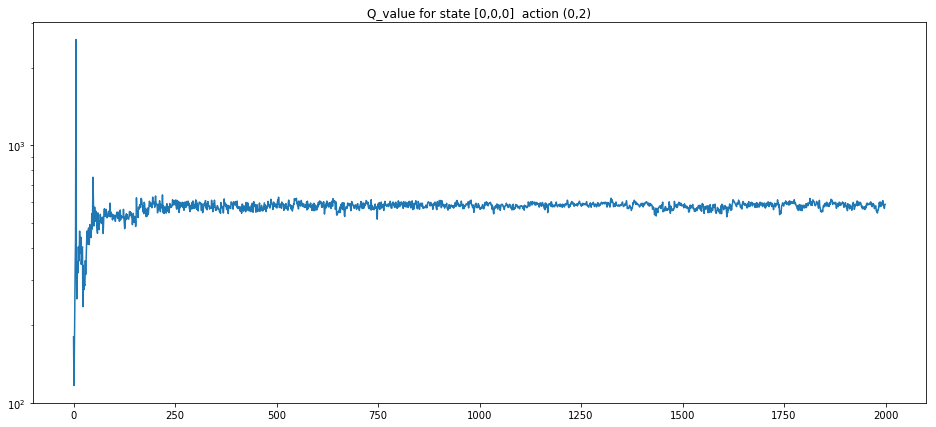

In [13]:
plt.figure(0, figsize=(16,7))
plt.title('Q_value for state [0,0,0]  action (0,2)')
xaxis = np.asarray(range(0, len(agent.states_tracked)))
plt.semilogy(xaxis,np.asarray(agent.states_tracked))
plt.show()

#### Tracking rewards per episode

In [14]:
score_tracked_sample = [score_tracked[i] for i in range(len(score_tracked)) if (i % 4 == 0)]

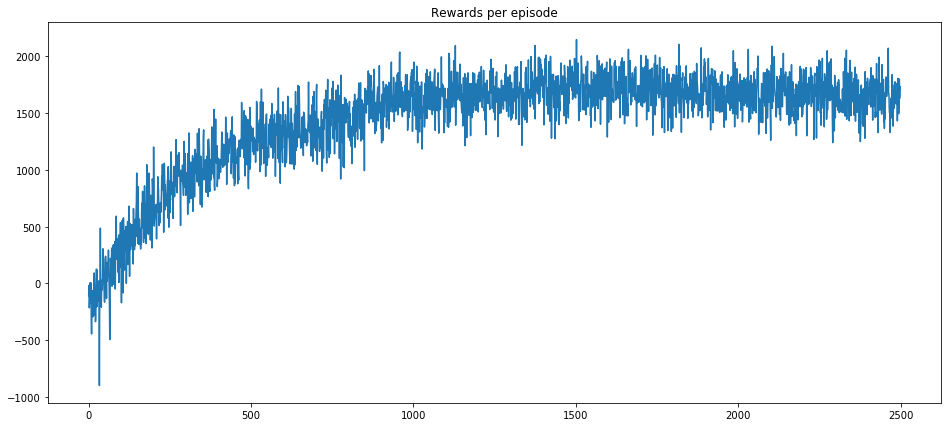

In [15]:
plt.figure(0, figsize=(16,7))
plt.title('Rewards per episode')
xaxis = np.asarray(range(0, len(score_tracked_sample)))
plt.plot(xaxis,np.asarray(score_tracked_sample))
plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [16]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

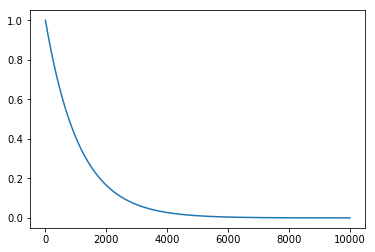

In [17]:
plt.plot(time, epsilon)
plt.show()